In [9]:
import sys
sys.path.append('/home/sharedrive/nafi/traffic/lib/python3.9/site-packages')

import pandas as pd
from chronos import ChronosPipeline
import torch
from table_evaluator import TableEvaluator
import matplotlib.pyplot as plt
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer, TVAESynthesizer
from sdv.metadata import Metadata
import numpy as np
from ctgan import CTGAN
from ctgan import load_demo
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
from table_evaluator import TableEvaluator
import pickle
import os
import time

In [10]:
cic_train_df = pd.read_csv("/home/sharedrive/nafi/trafficp3/cicidis/datasets/CICIDS_clean_train.csv")
cic_test_df = pd.read_csv("/home/sharedrive/nafi/trafficp3/cicidis/datasets/CICIDS_clean_test.csv")
cic_train_df.shape, cic_test_df.shape

((1979513, 25), (848363, 25))

In [11]:
cic_train_df.head()

,Flow_Duration,Total_Length_of_Bwd_Packets,Bwd_Packet_Length_Max,Bwd_Packet_Length_Mean,Flow_Bytes/s,Flow_Packets/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,...,Fwd_Packets/s,Bwd_Packets/s,Max_Packet_Length,Packet_Length_Mean,Average_Packet_Size,Avg_Bwd_Segment_Size,Subflow_Bwd_Bytes,Init_Win_bytes_forward,min_seg_size_forward,Label
0,160,248,124,124.0,2.500000e+06,25000.000000,5.333333e+01,8.631531e+01,153,3,...,12500.000000,12500.000000,124,95.2,119.000000,124.0,248,-1,20,BENIGN
1,62,6,6,6.0,9.677419e+04,32258.064520,6.200000e+01,0.000000e+00,62,62,...,16129.032260,16129.032260,6,2.0,3.000000,6.0,6,29200,40,PortScan
2,4,0,0,0.0,3.100000e+07,500000.000000,4.000000e+00,0.000000e+00,4,4,...,500000.000000,0.000000,62,62.0,93.000000,0.0,0,-1,20,BENIGN
3,164,46,23,23.0,5.609756e+05,24390.243900,5.466667e+01,9.382075e+01,163,0,...,12195.121950,12195.121950,23,23.0,28.750000,23.0,46,-1,32,BENIGN
4,6944519,30,6,5.0,2.023178e+02,1.007989,1.157420e+06,2.825515e+06,6924972,3,...,0.143998,0.863991,1375,347.5,397.142857,5.0,30,229,20,BENIGN


In [12]:
cic_train_df.drop(columns=["Init_Win_bytes_forward", "Flow_IAT_Min"], inplace=True)
cic_test_df.drop(columns=["Init_Win_bytes_forward", "Flow_IAT_Min"], inplace=True)
cic_train_df.shape, cic_test_df.shape

((1979513, 23), (848363, 23))

In [13]:
label_encoder = LabelEncoder()
scaler = StandardScaler()

In [14]:
def generate_data_for_classes_ctgan(df, classes, num_samples, num_epochs=500):
    synthetic_data = pd.DataFrame()
    metadata = Metadata.detect_from_dataframe(data=df)
    for cls in classes:
        selected_df = df[df["Label"] == cls]
        synthesizer = CTGANSynthesizer(metadata, epochs=num_epochs, verbose=True)
        synthesizer.fit(selected_df)
        samples = synthesizer.sample(num_samples)
        
        synthetic_data = pd.concat([synthetic_data, samples])
    return synthetic_data

In [15]:
small_classes = ['Web_Attack__XSS', 'Web_Attack__Brute_Force',
       'Web_Attack__Sql_Injection', 'Infiltration', 'Heartbleed', 'Bot']
save_path = "/home/sharedrive/nafi/trafficp3/cicidis"

def save_label_encoder(le, file_name):
    with open(f'{save_path}/models/{file_name}_label_encoder.pkl', 'wb') as le_file:
        pickle.dump(le, le_file)

def save_scaler(scaler, file_name):
    with open(f'{save_path}/models/{file_name}_scaler.pkl', 'wb') as scaler_file:
        pickle.dump(scaler, scaler_file)
    
def ctgan_train(train_df, epochi, file_name, reduced_test_df, rounds=0):

    for num_sample in [1000]:
        print(f"{file_name} epoch={epochi} samples={num_sample} round={rounds}")

        synthetic_file_path = f"{save_path}/datasets/{file_name}sample{num_sample}epoch{epochi}rounds{rounds}.csv"
        
        if os.path.exists(synthetic_file_path):
            print(f"Synthetic data already exists: {synthetic_file_path}")
            synthetic_data_df = pd.read_csv(synthetic_file_path)
        else:
            start_time = time.time()
            print("Generating synthetic data...") 
            synthetic_data = generate_data_for_classes_ctgan(train_df, small_classes, num_sample, epochi)

            # save and load synthetic data
            synthetic_data.to_csv(f'{save_path}/datasets/{file_name}sample{num_sample}epoch{epochi}rounds{rounds}.csv', index=False)
            synthetic_data_df = pd.read_csv(synthetic_file_path)
            
            elapsed_time = time.time() - start_time
            print(f"Execution time for generating data: {elapsed_time:.2f} seconds")

        # combine synthetic and real data
        combined_train_synth_df = pd.concat([train_df, synthetic_data_df], axis=0, ignore_index=True)

        # divide to x_train and y_train from reduced_train_df
        x_train = combined_train_synth_df.drop(columns=["Label"])
        y_train = combined_train_synth_df["Label"]
        x_test = reduced_test_df.drop(columns=["Label"])
        y_test = reduced_test_df["Label"]
        
        y_train = label_encoder.fit_transform(y_train) # Encode string labels into numeric format
        y_test = label_encoder.transform(y_test)
        x_train = scaler.fit_transform(x_train) # Standardize the features
        x_test = scaler.transform(x_test)
        save_label_encoder(label_encoder, file_name)
        save_scaler(scaler, file_name)

        RF_model = RandomForestClassifier(random_state=1002, verbose=2)
        RF_model.fit(x_train, y_train) #For sklearn no one hot encoding

        pred_rf = RF_model.predict(x_test)


        pickle.dump(RF_model, open(f'{save_path}/models/{file_name}sample{num_sample}epoch{epochi}rounds{rounds}.pkl', 'wb'))

        print(f"Classification Report for Sample Size {num_sample}:")
        print(classification_report(y_test, pred_rf, digits=4, target_names=label_encoder.classes_))

        # table_evaluator = TableEvaluator(train_df, synthetic_data_df)
        # print(table_evaluator.visual_evaluation())

In [16]:
ctgan_train(train_df=cic_train_df, epochi=1500, file_name='synthetic_from_cicids_ctgan', reduced_test_df=cic_test_df, rounds=1)

synthetic_from_cicids_ctgan epoch=1500 samples=1000 round=1
Generating synthetic data...


/home/sharedrive/nafi/traffic/lib/python3.9/site-packages/sdv/single_table/base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Gen. (1.06) | Discrim. (-1.11): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:28<00:00, 16.96it/s]
Gen. (-2.71) | Discrim. (-0.34): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:52<00:00,  8.67it/s]
Gen. (0.19) | Discrim. (-0.17): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:29<00:00, 16.80it/s]
Gen. (0.94) | Discrim. (-0.52): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:23<00:00, 17.86it/s]
Gen. (-1.71) | Discrim. (-0.53): 100%|███████████

Execution time for generating data: 714.17 seconds
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 10

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  4.8min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.5s


Classification Report for Sample Size 1000:
                           precision    recall  f1-score   support

                   BENIGN     0.9956    0.9902    0.9929    681396
                      Bot     0.7944    0.4872    0.6040       587
                     DDoS     0.9990    0.9985    0.9988     38408
            DoS_GoldenEye     0.9812    0.9809    0.9811      3088
                 DoS_Hulk     0.9166    0.9767    0.9457     69037
         DoS_Slowhttptest     0.9470    0.9848    0.9655      1650
            DoS_slowloris     0.9977    0.9954    0.9965      1739
              FTP-Patator     0.9979    0.9878    0.9928      2380
               Heartbleed     1.0000    1.0000    1.0000         3
             Infiltration     0.7273    0.7273    0.7273        11
                 PortScan     0.9934    0.9995    0.9965     47641
              SSH-Patator     0.9967    0.5150    0.6791      1769
  Web_Attack__Brute_Force     0.7186    0.6836    0.7007       452
Web_Attack__Sql_I

In [17]:
ctgan_train(train_df=cic_train_df, epochi=1500, file_name='synthetic_from_cicids_ctgan', reduced_test_df=cic_test_df, rounds=2)

synthetic_from_cicids_ctgan epoch=1500 samples=1000 round=2
Generating synthetic data...


/home/sharedrive/nafi/traffic/lib/python3.9/site-packages/sdv/single_table/base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Gen. (0.14) | Discrim. (-0.60): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:27<00:00, 17.08it/s]
Gen. (-1.80) | Discrim. (-0.42): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:49<00:00,  8.86it/s]
Gen. (0.60) | Discrim. (-0.23): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:27<00:00, 17.10it/s]
Gen. (1.17) | Discrim. (-0.25): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:23<00:00, 17.99it/s]
Gen. (-0.69) | Discrim. (-0.72): 100%|███████████

Execution time for generating data: 703.92 seconds
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 10

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  4.9min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.5s


Classification Report for Sample Size 1000:
                           precision    recall  f1-score   support

                   BENIGN     0.9956    0.9902    0.9929    681396
                      Bot     0.7967    0.4872    0.6047       587
                     DDoS     0.9990    0.9986    0.9988     38408
            DoS_GoldenEye     0.9806    0.9828    0.9817      3088
                 DoS_Hulk     0.9167    0.9768    0.9458     69037
         DoS_Slowhttptest     0.9475    0.9848    0.9658      1650
            DoS_slowloris     0.9983    0.9954    0.9968      1739
              FTP-Patator     0.9979    0.9878    0.9928      2380
               Heartbleed     1.0000    0.6667    0.8000         3
             Infiltration     0.6667    0.7273    0.6957        11
                 PortScan     0.9935    0.9995    0.9965     47641
              SSH-Patator     0.9967    0.5150    0.6791      1769
  Web_Attack__Brute_Force     0.7185    0.6947    0.7064       452
Web_Attack__Sql_I

In [18]:
ctgan_train(train_df=cic_train_df, epochi=1500, file_name='synthetic_from_cicids_ctgan', reduced_test_df=cic_test_df, rounds=3)

synthetic_from_cicids_ctgan epoch=1500 samples=1000 round=3
Generating synthetic data...


/home/sharedrive/nafi/traffic/lib/python3.9/site-packages/sdv/single_table/base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Gen. (-0.38) | Discrim. (-1.06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:26<00:00, 17.25it/s]
Gen. (-1.98) | Discrim. (-0.63): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:47<00:00,  8.94it/s]
Gen. (-1.12) | Discrim. (-0.22): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:27<00:00, 17.15it/s]
Gen. (0.66) | Discrim. (-0.51): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:22<00:00, 18.27it/s]
Gen. (-1.49) | Discrim. (-0.18): 100%|███████████

Execution time for generating data: 700.53 seconds
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 10

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  4.8min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.4s


Classification Report for Sample Size 1000:
                           precision    recall  f1-score   support

                   BENIGN     0.9956    0.9902    0.9929    681396
                      Bot     0.7901    0.4872    0.6027       587
                     DDoS     0.9990    0.9985    0.9987     38408
            DoS_GoldenEye     0.9822    0.9812    0.9817      3088
                 DoS_Hulk     0.9167    0.9768    0.9458     69037
         DoS_Slowhttptest     0.9470    0.9861    0.9662      1650
            DoS_slowloris     0.9977    0.9954    0.9965      1739
              FTP-Patator     0.9979    0.9878    0.9928      2380
               Heartbleed     1.0000    1.0000    1.0000         3
             Infiltration     0.6667    0.7273    0.6957        11
                 PortScan     0.9934    0.9995    0.9965     47641
              SSH-Patator     0.9978    0.5150    0.6793      1769
  Web_Attack__Brute_Force     0.7246    0.7102    0.7173       452
Web_Attack__Sql_I

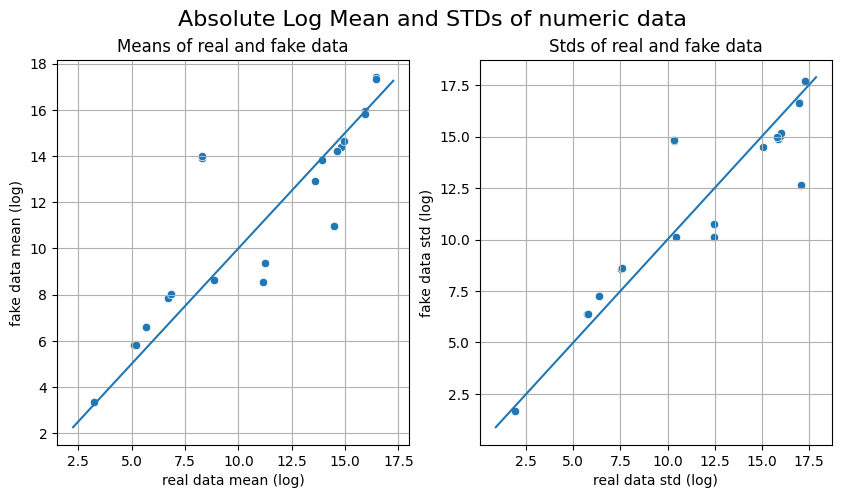

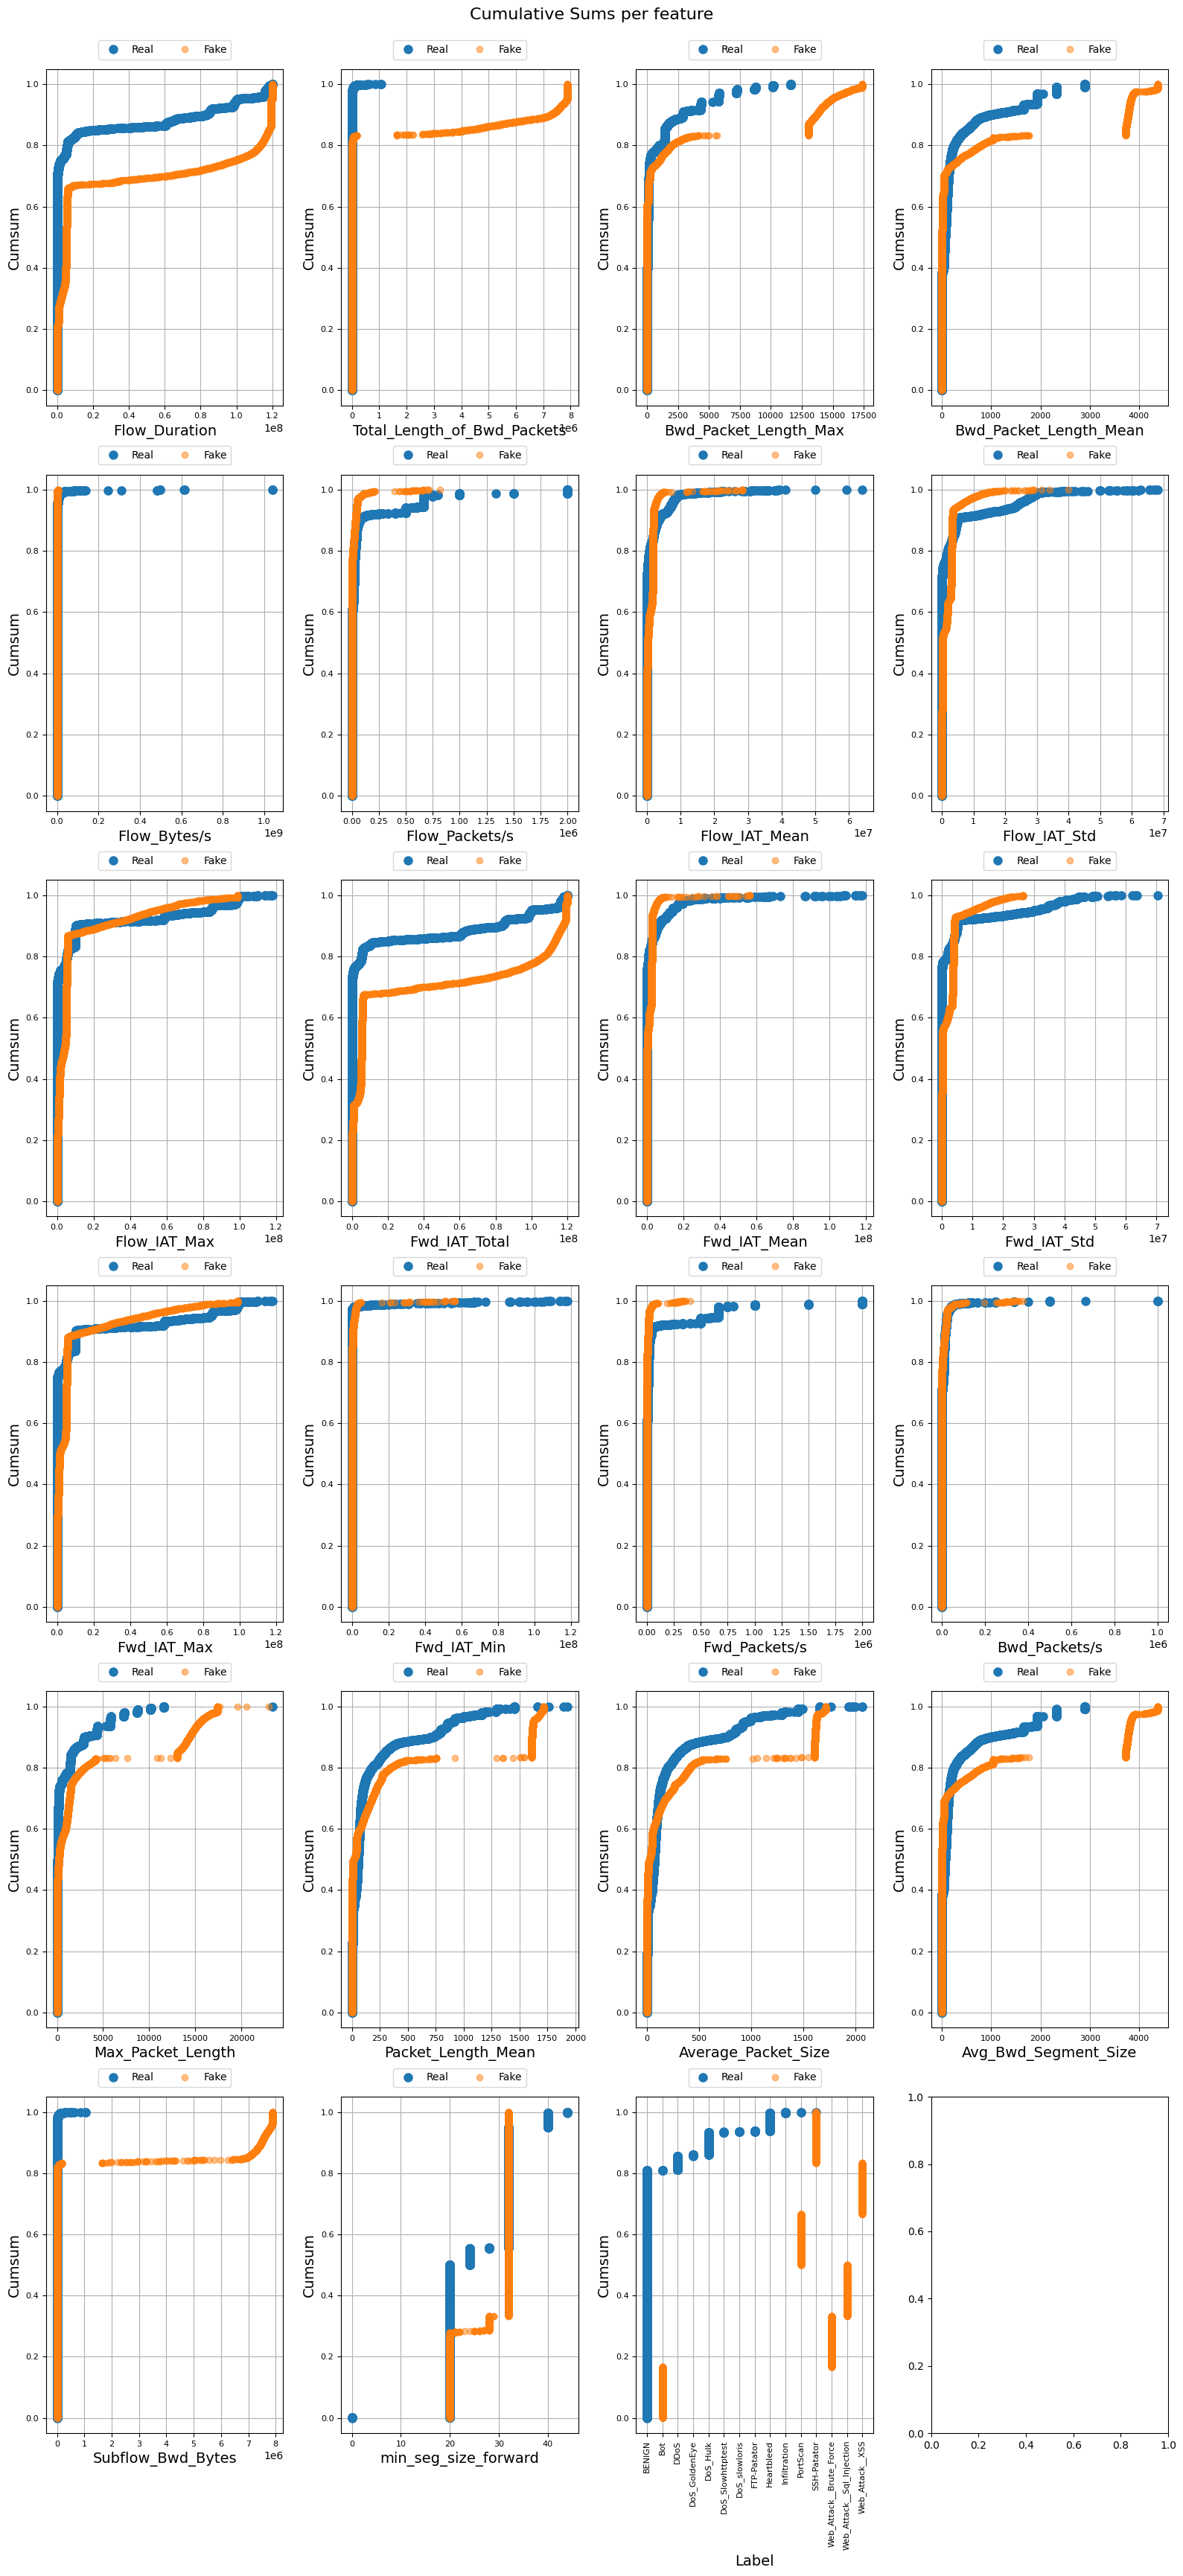

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f5dd18fac10> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f5d868b4280> (for post_execute):


KeyboardInterrupt: 

In [19]:
def table_evaluator(file_name="synthetic_from_cicids_ctgan", epochi=1500, num_sample=1000, rounds=1):
    synthetic_file_path = f"{save_path}/datasets/{file_name}sample{num_sample}epoch{epochi}rounds{rounds}.csv"
    syn_data = pd.read_csv(synthetic_file_path)
    table_evaluator = TableEvaluator(cic_train_df, syn_data)
    print(table_evaluator.visual_evaluation())
table_evaluator(rounds=1)

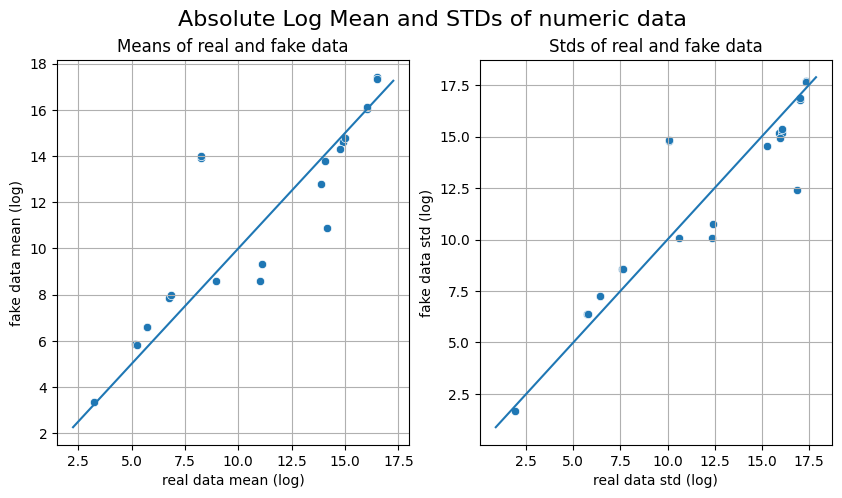

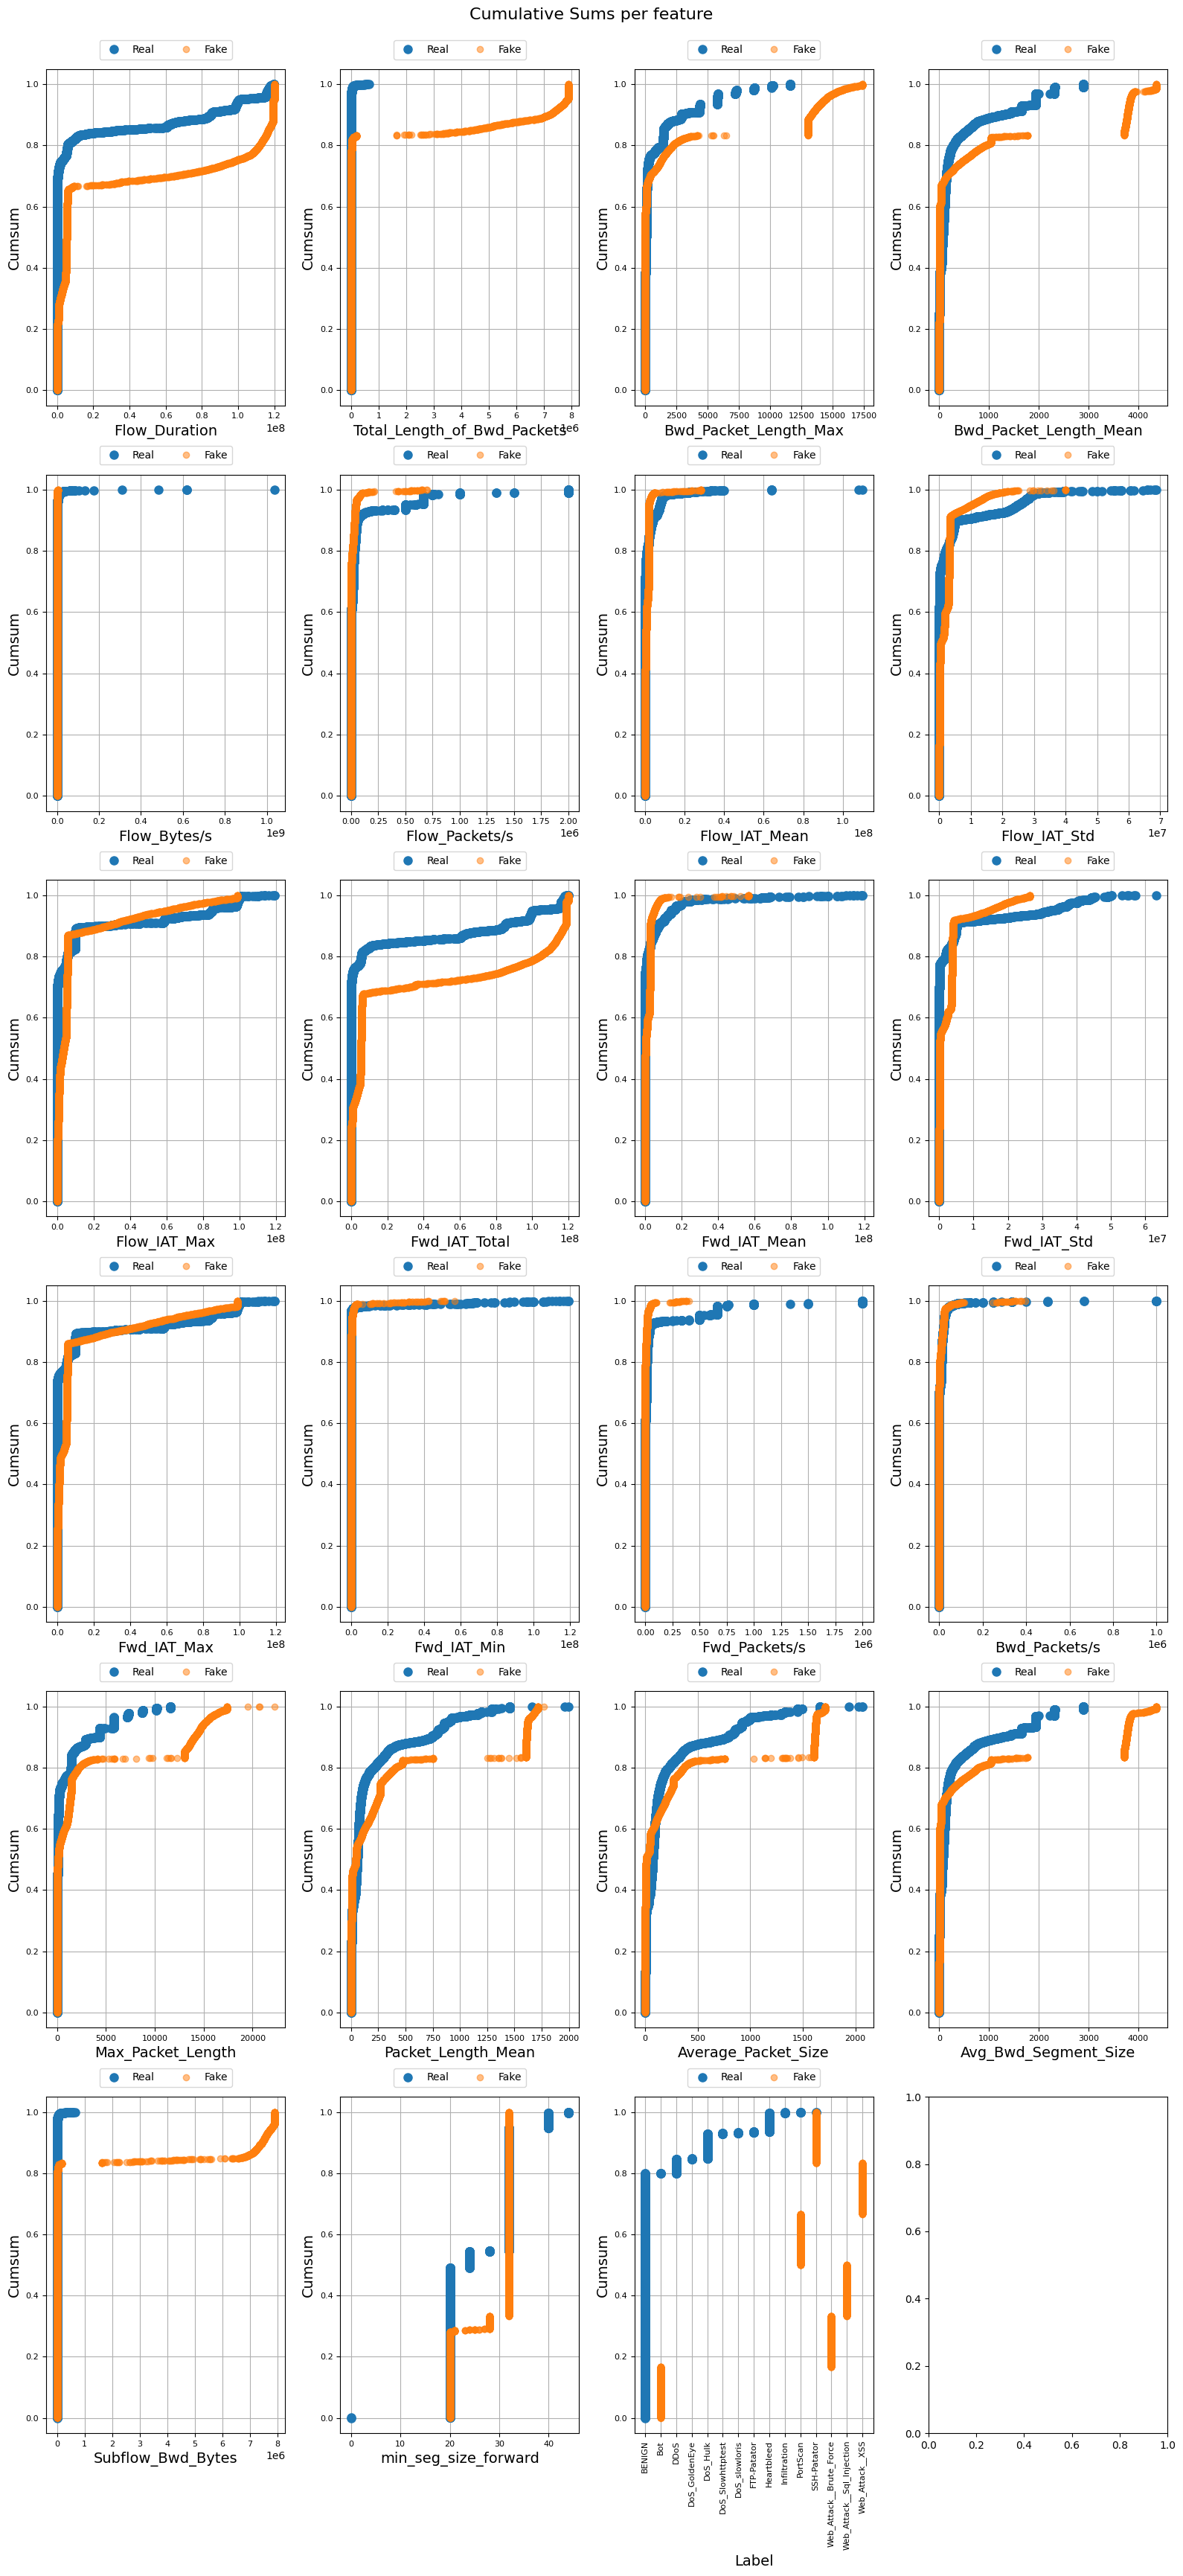

KeyboardInterrupt: 

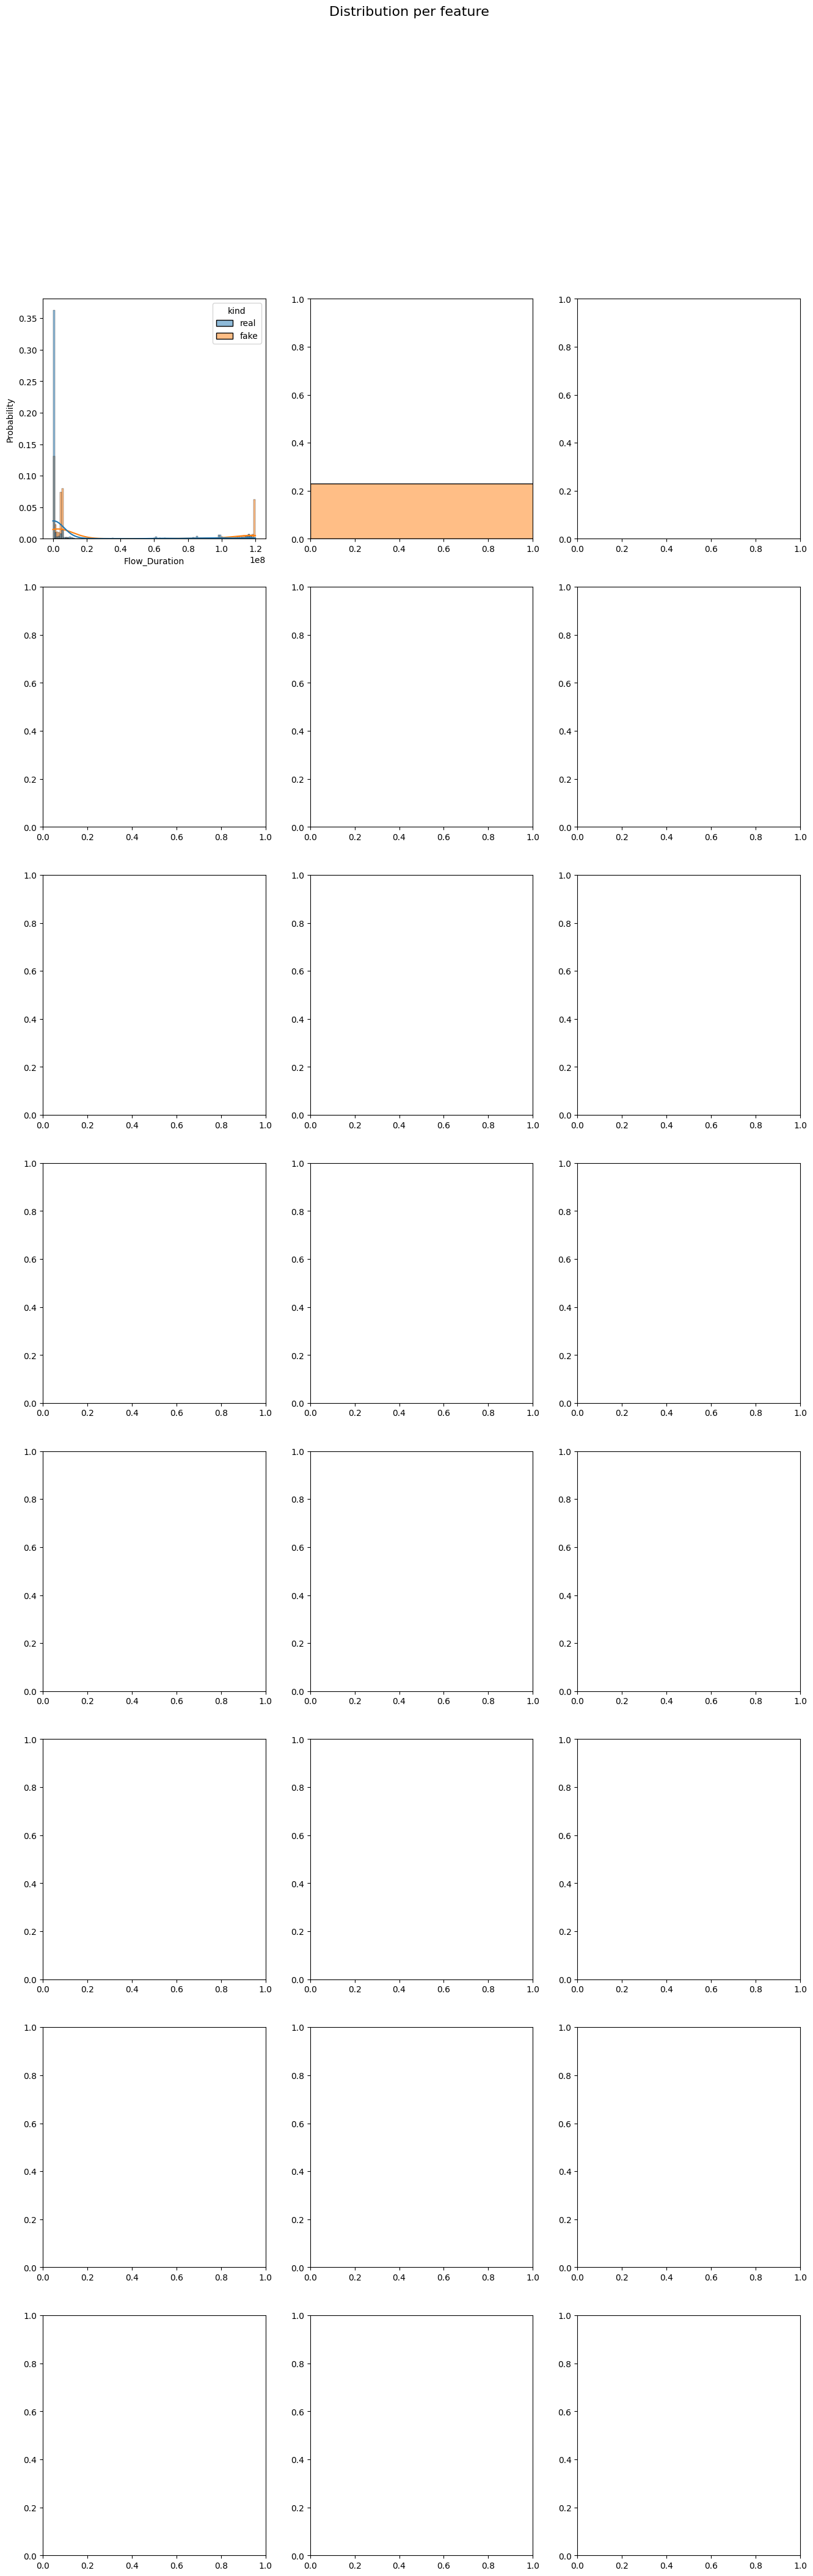

In [20]:
table_evaluator(rounds=2)

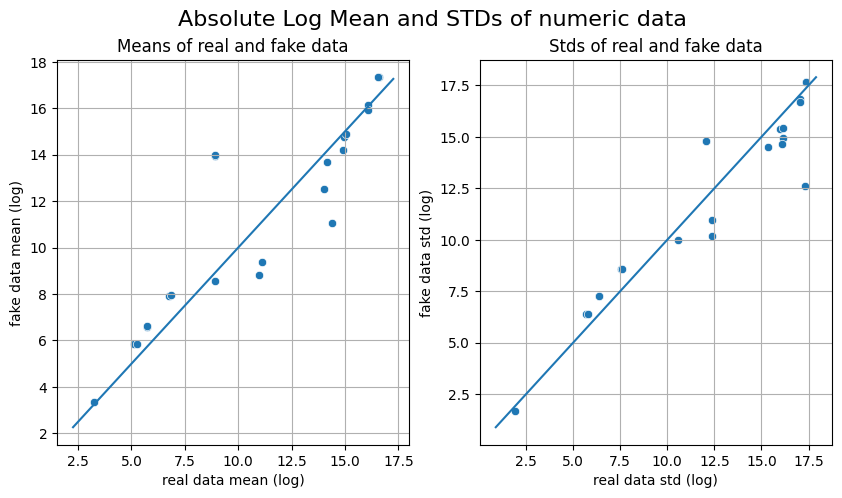

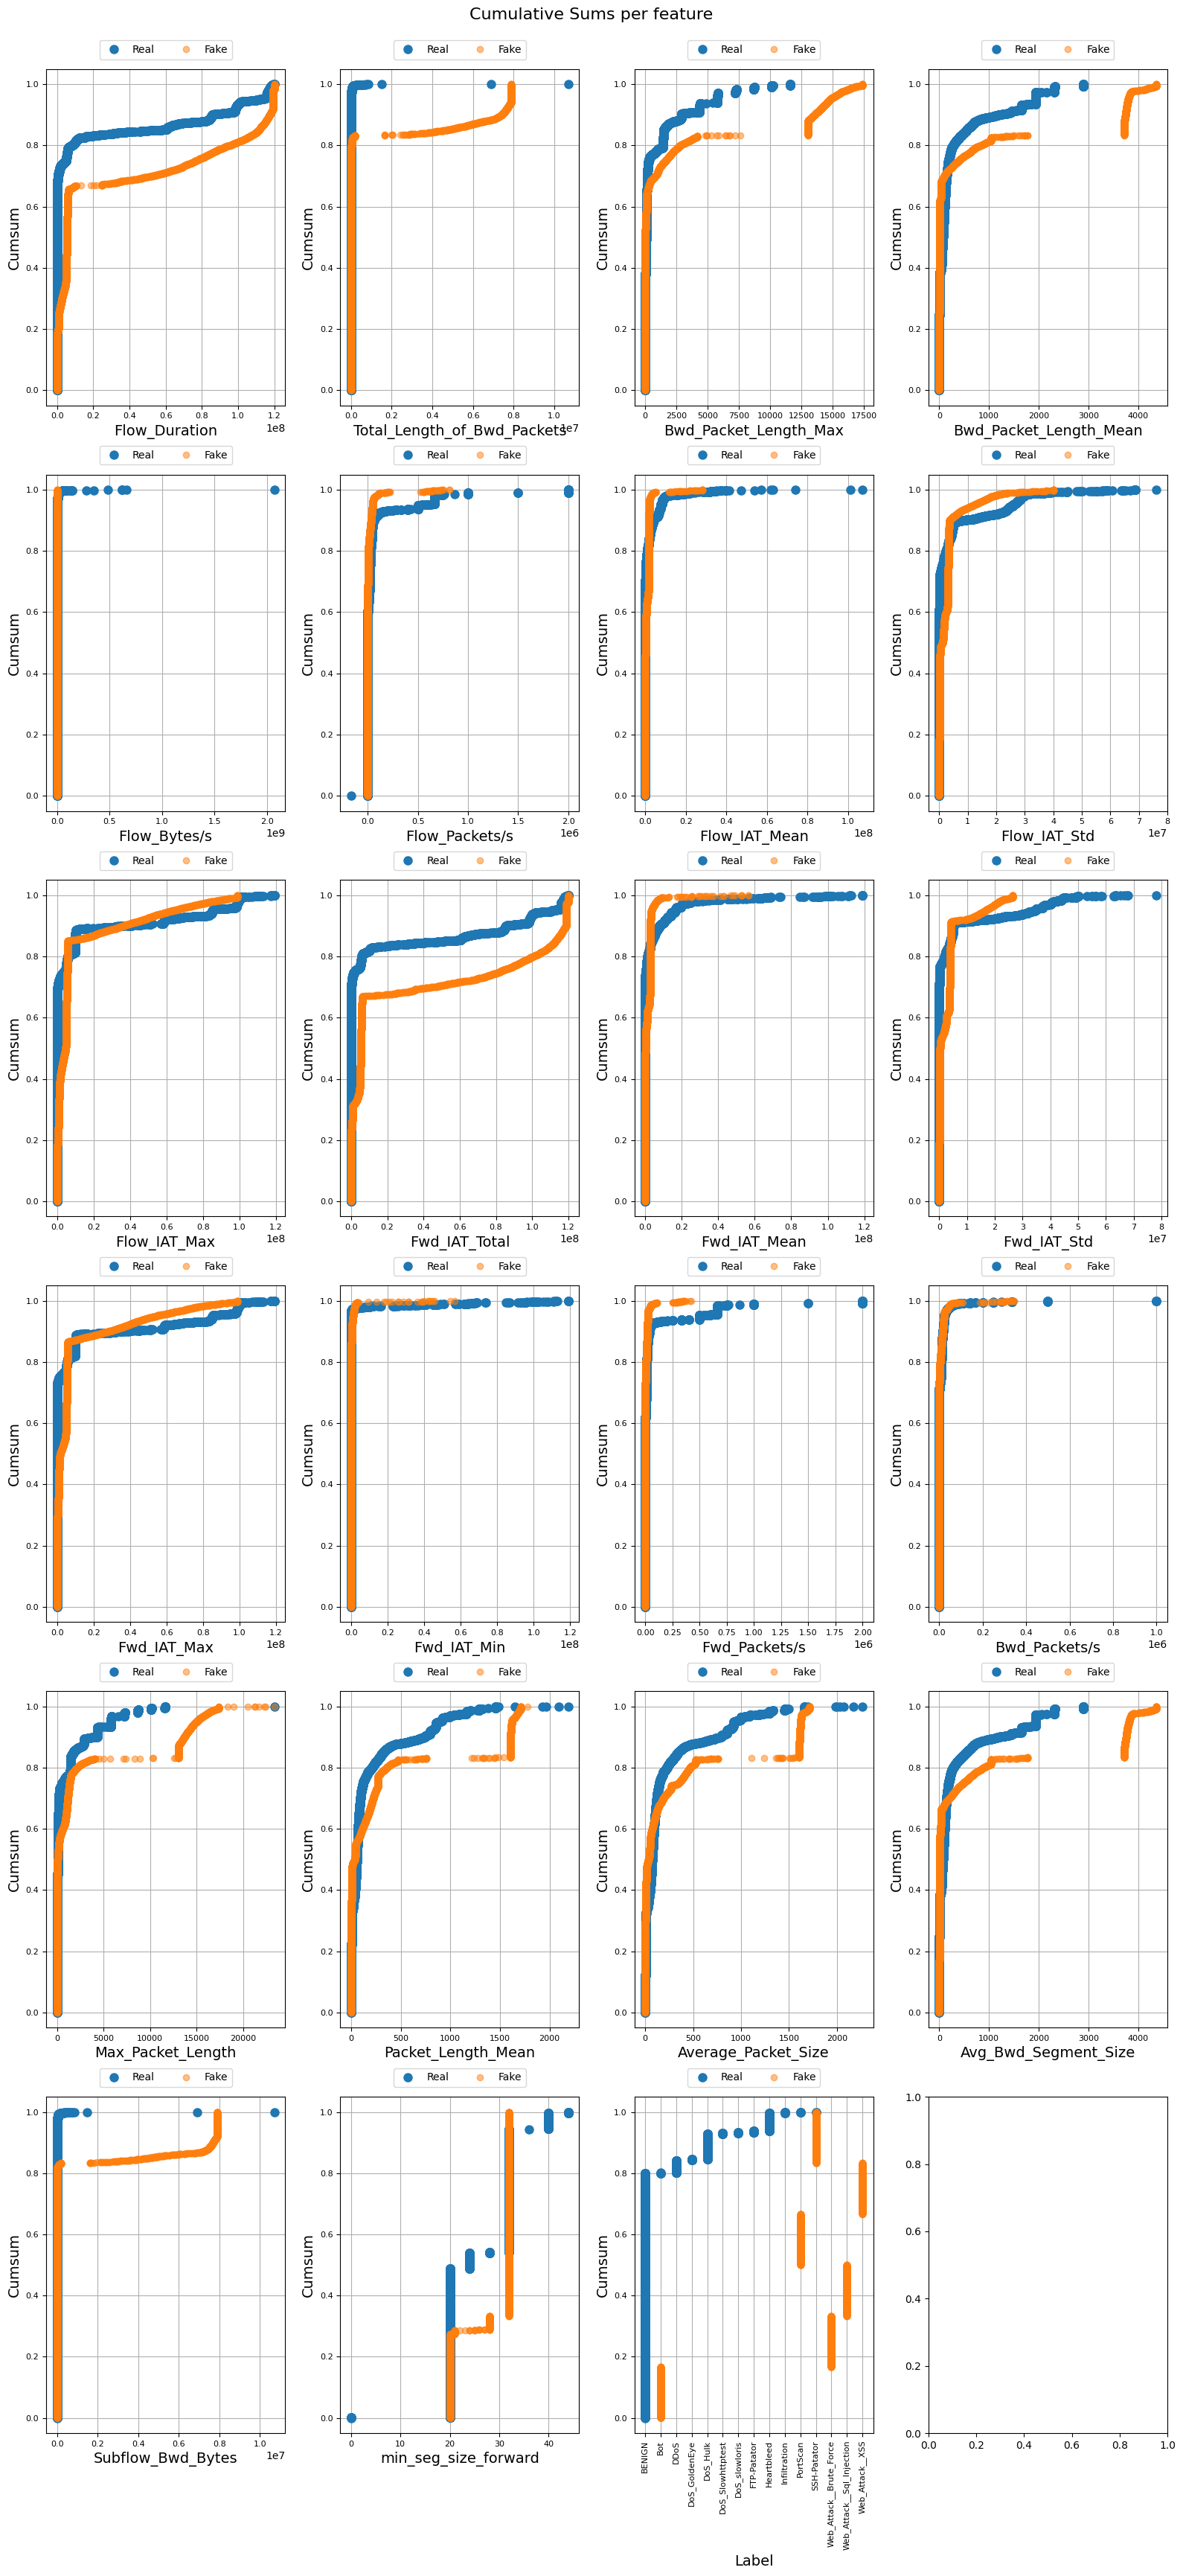

KeyboardInterrupt: 

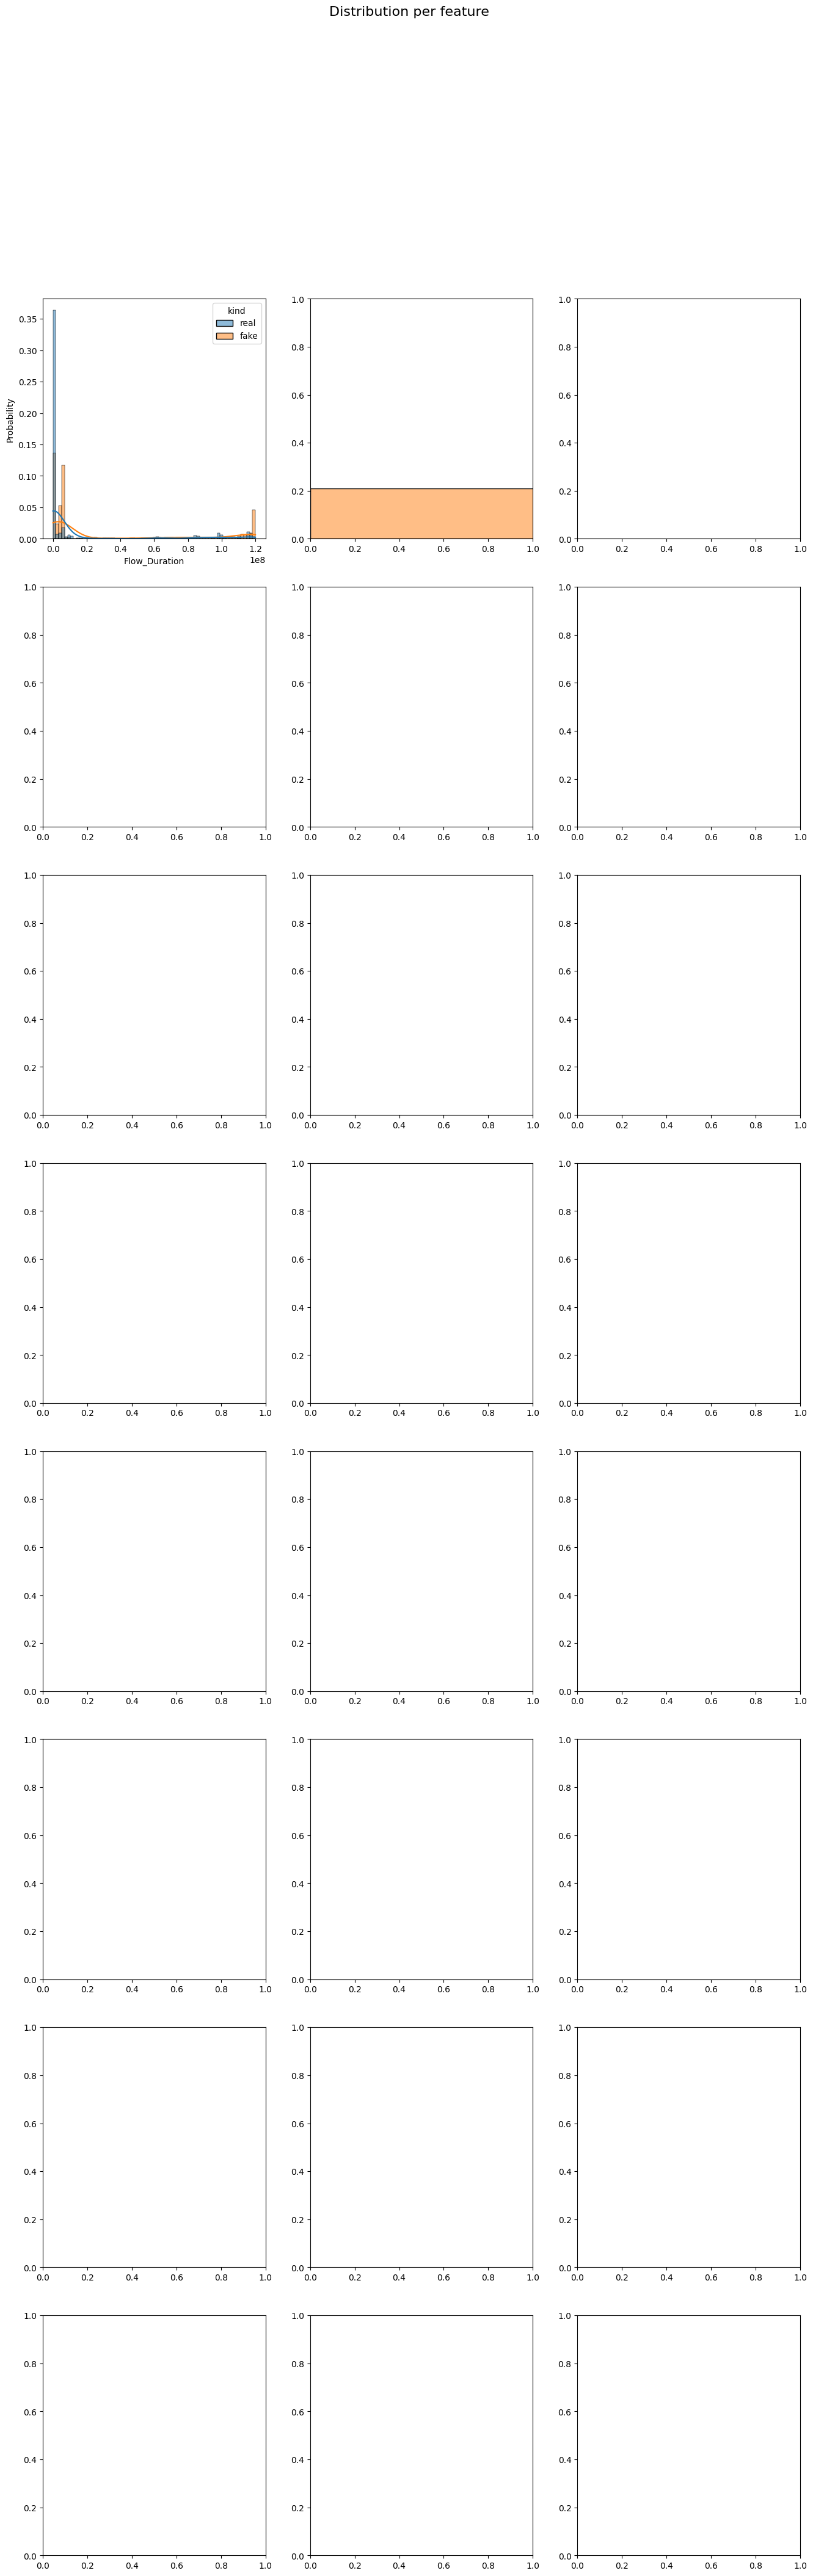

In [21]:
table_evaluator(rounds=3)